# Activate Local Environment

In [1]:
] activate .

  Activating environment at `B:\Uni\Hauptstudium\DMML\ml1\julia\Project.toml`


# Imports

In [2]:
using DataFrames
using CSV
using PandasHelpers
using Dates
using ShiftedArrays
using Statistics
using Plots

In [3]:
import Base.>
import Base.Bool

In [4]:
using Flux

# Hyperparameters and Function Definition

In [5]:
# hyperparameters
SHIFT = [1,2,5]
NUM_EPOCHS = 50
DECISION_BOUNDARY = 0.4

0.4

In [6]:
# define any number to be bigger than missing
(>)(a::Number, b::Missing)  = true
# define any real number but 0 to be true
Bool(a::Real) = a == 0 ? false : true

Bool

In [7]:
# split datetime into weekday, hour and minute
function split_dt(dt)
    [Dates.dayofweek(dt), Dates.hour(dt), Dates.minute(dt)]
end
# create new column whether there was a rise when compared to <shift> columns before
function didrise!(df::DataFrame, cols::Vector{String}, shift::Number)
    for col in cols
        df[:, "change_$(col)_$(shift)"] = BitArray(df[:, col] .> ShiftedArray(df[:, col], shift))
    end
end

didrise! (generic function with 1 method)

In [8]:
# Data Pipeline
function pipeline(raw::DataFrame, shifts)
    # create copy without index
    df = copy(raw[:, Not(:index)])
    # convert to DateTime round to the nearest minute
    select!(df, :Datum => ByRow(x->round(DateTime(x, "yyyy-mm-dd HH:MM:SS"), Dates.Minute)) => :Datum, :)
    # create columns for weekday, hour and minute, drop column Datum
    select!(df, :Datum => ByRow(x -> split_dt(x)) => [:Wochentag, :Stunde, :Minute] , Not(:Datum))
    # impute missing values
    naive_impute!(df.Temperatur)
    naive_impute!(df.Luftfeuchtigkeit)
    naive_impute!(df.CO2)
    # dummy encode weekday and hour
    get_dummies!(df, "Wochentag")
    get_dummies!(df, "Stunde")
    # create columns for relative change of temperature, humidity and co2
    for shift in shifts
        didrise!(df, ["Temperatur", "Luftfeuchtigkeit", "CO2", "Wassergehalt"], shift)
    end
    # abs max normalize 
    abs_max_norm!(df, names(df))
    return df
end

pipeline (generic function with 1 method)

In [9]:
# neccessary transformation for prediction
function predict(x, threshold)
    # transpose, shift by threshold and round
    round.(vec(model(transpose(Array(x)))) .+ (0.5-threshold))
end

predict (generic function with 1 method)

In [10]:
# count tp, fp, fn, tn and optionally display confusion matrix
function confusion_matrix(ŷ, y; draw=false)
    ŷ = Bool.(ŷ)
    y = Bool.(y)
    tp = fp = fn = tn = 0
    for (i,j) in zip(ŷ, y)
        if i & j
            tp += 1
        elseif i & !j
            fp +=1
        elseif !i & j
            fn += 1
        else
            tn += 1
        end
    end
    if draw
        display(["Confusion Matrix" "Y" "!Y" ; "Ŷ" tp fp; "!Ŷ" fn tn])
    end
    return [tp, fp, fn, tn]
end

confusion_matrix (generic function with 1 method)

In [11]:
# draw ROC curve
function draw_roc()
    thresholds = 0:0.01:1.01
    metrics = [confusion_matrix(predict(val_x, threshold), val_y, draw=false) for threshold in thresholds]
    tprs = [tp/(tp+fn) for (tp, fp, fn, tn) in metrics]
    fprs = [fp/(fp+tn) for (tp, fp, fn, tn) in metrics]
    plot(fprs, tprs, label="ROC")
    plot!([0,1],[0,1], label="Baseline")
end

draw_roc (generic function with 1 method)

# Preprocessing

In [12]:
# read raw data
raw = DataFrame(CSV.File("train.csv"))
# split into train and validation set
train_x, train_y, val_x, val_y = train_test_split(pipeline(raw, SHIFT), "Anwesenheit"; ratio=0.9)
nothing

# Modelling

In [14]:
# Baseline A <slide>, big network, no dropout, no batchnorm
model = Chain(
    Dense(size(train_x)[2], 256, relu),
    Dense(256,128, relu),
    Dense(128,64, relu),
    Dense(64,32, relu),
    Dense(32,16, relu),
    Dense(16, 1, sigmoid)
    )

Chain(
  Dense(48, 256, relu),                 # 12_544 parameters
  Dense(256, 128, relu),                # 32_896 parameters
  Dense(128, 64, relu),                 # 8_256 parameters
  Dense(64, 32, relu),                  # 2_080 parameters
  Dense(32, 16, relu),                  # 528 parameters
  Dense(16, 1, σ),                      # 17 parameters
)                   # Total: 12 arrays, 56_321 parameters, 220.754 KiB.

In [15]:
# Baseline B <mountain>, semi big , with dropout and batchnorm
model = Chain(
    Dense(size(train_x)[2], 16, relu),
    BatchNorm(16, relu),
    Dropout(0.1),
    Dense(16,128, relu),
    BatchNorm(128, relu),
    Dropout(0.1),
    Dense(128,64, relu),
    BatchNorm(64, relu),
    Dropout(0.1),
    Dense(64,16, relu),
    BatchNorm(16, relu),
    Dropout(0.1),
    Dense(16, 1, sigmoid)
    )

Chain(
  Dense(48, 16, relu),                  # 784 parameters
  BatchNorm(16, relu),                  # 32 parameters, plus 32
  Dropout(0.1),
  Dense(16, 128, relu),                 # 2_176 parameters
  BatchNorm(128, relu),                 # 256 parameters, plus 256
  Dropout(0.1),
  Dense(128, 64, relu),                 # 8_256 parameters
  BatchNorm(64, relu),                  # 128 parameters, plus 128
  Dropout(0.1),
  Dense(64, 16, relu),                  # 1_040 parameters
  BatchNorm(16, relu),                  # 32 parameters, plus 32
  Dropout(0.1),
  Dense(16, 1, σ),                      # 17 parameters
)         # Total: 18 trainable arrays, 12_721 parameters,
          # plus 8 non-trainable, 448 parameters, summarysize 53.098 KiB.

In [ ]:
# Baseline C <flat>, small network with dropout, no batchnorm
model = Chain(
    Dense(size(train_x)[2], 8, tanh),
    BatchNorm(8, relu),
    Dropout(0.05),
    Dense(8, 8, tanh),
    BatchNorm(8, relu),
    Dropout(0.05),
    Dense(8, 1, sigmoid)
    )

In [16]:
# Optimizer https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam
opt = ADAM(0.001, (0.9, 0.999))
# pointer to parameters
ps = Flux.params(model)
# loss function
loss((x,y)) = Flux.Losses.binarycrossentropy(transpose(model(x)), y)
# dataloader object for convenience
data = Flux.Data.DataLoader((data=transpose(Array(train_x)), label=train_y), batchsize=100,shuffle=true)

Flux.Data.DataLoader{NamedTuple{(:data, :label), Tuple{LinearAlgebra.Transpose{Float64, Matrix{Float64}}, Vector{Float64}}}, Random._GLOBAL_RNG}((data = [0.6949152542372882 0.8983050847457628 … 0.4406779661016949 0.15254237288135594; 0.8398770911573927 0.805052919085013 … 0.9054284738818723 0.9787640833048836; … ; 1.0 0.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0], label = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0  …  1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]), 100, 12817, true, 12817, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  12808, 12809, 12810, 12811, 12812, 12813, 12814, 12815, 12816, 12817], true, Random._GLOBAL_RNG())

In [17]:
# training loop
for epoch in 1:NUM_EPOCHS
    # train
    Flux.train!(loss, ps, data, opt)
    # every five epochs compute accuracy on train and validation samples
    if epoch % 5 == 0
        ŷ = predict(train_x, DECISION_BOUNDARY)
        (tp, fp, fn, tn) = confusion_matrix(ŷ, train_y)
        acc = round((tp+tn) / (tp+fp+fn+tn), digits=4)
        ŷ = predict(val_x, DECISION_BOUNDARY)
        (tp, fp, fn, tn) = confusion_matrix(ŷ, val_y)
        val_acc = round((tp+tn) / (tp+fp+fn+tn), digits=4)
        println("Epoch: $(epoch) Accuracy: $(acc) Val-Accuracy: $(val_acc)")
    end
end

Epoch: 5 Accuracy: 0.959 Val-Accuracy: 0.9558
Epoch: 10 Accuracy: 0.97 Val-Accuracy: 0.9649
Epoch: 15 Accuracy: 0.9754 Val-Accuracy: 0.9649
Epoch: 20 Accuracy: 0.9797 Val-Accuracy: 0.9712
Epoch: 25 Accuracy: 0.9819 Val-Accuracy: 0.9761
Epoch: 30 Accuracy: 0.9835 Val-Accuracy: 0.9747
Epoch: 35 Accuracy: 0.9814 Val-Accuracy: 0.9747
Epoch: 40 Accuracy: 0.9856 Val-Accuracy: 0.9761
Epoch: 45 Accuracy: 0.9841 Val-Accuracy: 0.974
Epoch: 50 Accuracy: 0.9876 Val-Accuracy: 0.9775


# Evaluation

In [18]:
# draw confusion matrix
(tp, fp, fn, tn) = confusion_matrix(predict(val_x, 0.5), val_y, draw=true)

3×3 Matrix{Any}:
 "Confusion Matrix"     "Y"      "!Y"
 "Ŷ"                360       16
 "!Ŷ"                15     1033

4-element Vector{Int64}:
  360
   16
   15
 1033

In [19]:
# recall
tp / (fn + tp)

0.96

In [20]:
# precision
tp / (tp+fp)

0.9574468085106383

## ROC

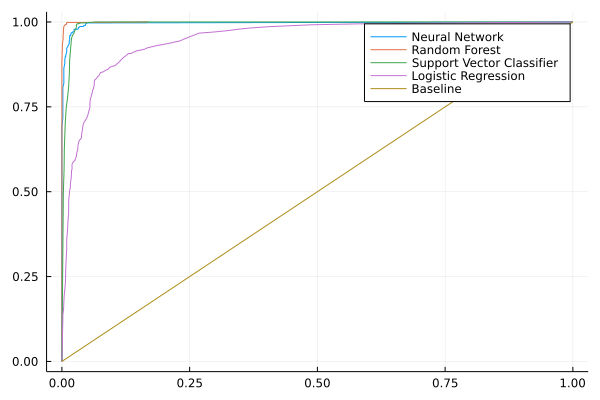

In [26]:
# read tpr and fpr of other models
roc_rf = DataFrame(CSV.File("./../ROC_RF.csv"))
roc_svc = DataFrame(CSV.File("./../roc_values_SVC.csv"))
roc_log_reg = DataFrame(CSV.File("./../ROC_Log Reg.csv"))
# draw ROC
thresholds = 0:0.01:1
# compute tprs and fprs for thresholds
metrics = [confusion_matrix(predict(val_x, threshold), val_y, draw=false) for threshold in thresholds]
tprs = [tp/(tp+fn) for (tp, fp, fn, tn) in metrics]
fprs = [fp/(fp+tn) for (tp, fp, fn, tn) in metrics]
# plot fpr vs tpr for neural network, random forest and svc
plot(fprs, tprs, label="Neural Network")
plot!(roc_rf.FPR, roc_rf.TPR, label="Random Forest")
plot!(roc_svc.FPR, roc_svc.TPR, label="Support Vector Classifier")
plot!(roc_log_reg.FPR, roc_log_reg.TPR, label="Logistic Regression")
# plot baseline
plot!([0,1],[0,1], label="Baseline")

# Prediction

In [23]:
# read train data
test_raw = DataFrame(CSV.File("test.csv"))
# transform and join with empty copy of train_x to mimic feature order
test = vcat(similar(train_x,0), pipeline(test_raw, SHIFT), cols=:union)
# fill missing values
replace!.(eachcol(test), missing=>0)
nothing

In [24]:
test_raw[!, "Anwesenheit"] = predict(test, 0.6)

6319-element Vector{Float64}:
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
 -0.0
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0

In [ ]:
# write to disk
CSV.write("nn_output.csv", test_raw)

In [25]:
# split date
select!(test_raw, :Datum => ByRow(x->round(DateTime(x, "yyyy-mm-dd HH:MM:SS"), Dates.Minute)) => :Datum, :)
select!(test_raw, :Datum => ByRow(x -> split_dt(x)) => [:Wochentag, :Stunde, :Minute] , Not(:Datum))
# display grouped by weekday
gdf = groupby(test_raw, [:Stunde])
combine(gdf, :Anwesenheit => sum)[:, :]

,Stunde,Anwesenheit_sum
,Int64,Float64
1,0,10.0
2,1,24.0
3,2,12.0
4,3,6.0
5,4,31.0
6,5,53.0
7,6,33.0
8,7,64.0
9,8,115.0
